#### VARIABLES

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
basepath = "dades_tfg/data"
demographics = pd.read_csv(os.path.join(basepath, "demographics.csv"))
demographics_N = pd.read_csv(os.path.join(basepath, "demographics_N.csv"))
nodes = pd.read_csv(os.path.join(basepath, "nodes.csv"))
basepath_FA = os.path.join(basepath, "FA")
basepath_GM = os.path.join(basepath, "GM")
basepath_RS = os.path.join(basepath, "RS")

In [3]:
filenames = ["{:04d}.csv".format(x) for x in demographics["id"]]

In [4]:
data_FA = np.zeros(shape=(len(filenames), 76, 76))
data_GM = np.zeros(shape=(len(filenames), 76, 76))
data_RS = np.zeros(shape=(len(filenames), 76, 76))

In [5]:
for i, filename in enumerate(filenames):
    df_FA = pd.read_csv(os.path.join(basepath_FA, filename), header=None)
    data_FA[i,:,:] = df_FA.values
    
    df_GM = pd.read_csv(os.path.join(basepath_GM, filename), header=None)
    data_GM[i,:,:] = df_GM.values
    
    df_RS = pd.read_csv(os.path.join(basepath_RS, filename), header=None)
    data_RS[i,:,:] = df_RS.values

In [6]:
basepath_FA_N = "dades_tfg/data/Naples/DTI_networks"
basepath_GM_N = "dades_tfg/data/Naples/GM_networks"
basepath_RS_N = "dades_tfg/data/Naples/rsfmri_networks"

# Listar nombres de archivos CSV en cada carpeta
filenames_FA_N = sorted([f for f in os.listdir(basepath_FA_N) if f.endswith('.csv')])
filenames_GM_N = sorted([f for f in os.listdir(basepath_GM_N) if f.endswith('.csv')])
filenames_RS_N = sorted([f for f in os.listdir(basepath_RS_N) if f.endswith('.csv')])

In [7]:
# Inicializar arrays para almacenar los datos
data_FA_N = np.zeros((len(filenames_FA_N), 76, 76))  
data_GM_N = np.zeros((len(filenames_GM_N), 76, 76))
data_RS_N = np.zeros((len(filenames_RS_N), 76, 76))

In [8]:
# FA
for i, filename in enumerate(filenames_FA_N):
    df_FA_N = pd.read_csv(os.path.join(basepath_FA_N, filename), header=None)
    data_FA_N[i, :, :] = df_FA_N.values

#  GM
for i, filename in enumerate(filenames_GM_N):
    df_GM_N = pd.read_csv(os.path.join(basepath_GM_N, filename), header=None)
    data_GM_N[i, :, :] = df_GM_N.values

#  RS
for i, filename in enumerate(filenames_RS_N):
    df_RS_N = pd.read_csv(os.path.join(basepath_RS_N, filename), header=None)
    data_RS_N[i, :, :] = df_RS_N.values

In [9]:
num_samples_FA = len(data_FA)
num_samples_FA_N = len(data_FA_N)
num_samples_GM = len(data_FA)
num_samples_GM_N = len(data_FA_N)
num_samples_RS = len(data_FA)
num_samples_RS_N = len(data_FA_N)


data_FA_combined = np.zeros((num_samples_FA + num_samples_FA_N, 76, 76))  
data_FA_combined[:num_samples_FA, :, :] = data_FA
data_FA_combined[num_samples_FA:, :, :] = data_FA_N


data_GM_combined = np.zeros((num_samples_GM + num_samples_GM_N, 76, 76))  
data_GM_combined[:num_samples_GM, :, :] = data_GM
data_GM_combined[num_samples_GM:, :, :] = data_GM_N


data_RS_combined = np.zeros((num_samples_RS + num_samples_RS_N, 76, 76))  
data_RS_combined[:num_samples_RS, :, :] = data_RS
data_RS_combined[num_samples_RS:, :, :] = data_RS_N

In [10]:
demographics_N['mstype'] = demographics_N['mstype'].apply(lambda x: 0 if x == -1 else 1)

# Embeddings

In [11]:
from gensim.models.word2vec import Word2Vec
#!pip install node2vec
from node2vec import Node2Vec

### EMBEDDING PER INDIVIDU

In [12]:
individual_sequences = []

num_regions_per_individual = 76

for i in range(0, data_FA_combined.shape[0], num_regions_per_individual):
    individual_data = []
    for j in range(num_regions_per_individual):
        idx = i + j
        if idx < data_FA_combined.shape[0]:
            fa_str = f"fa_{data_FA_combined[idx].mean():.4f}"
            gm_str = f"gm_{data_GM_combined[idx].mean():.4f}"
            rs_str = f"rs_{data_RS_combined[idx].mean():.4f}"
            individual_data.extend([fa_str, gm_str, rs_str])
    individual_sequences.append(individual_data)

#document -> 1 individu embedding x individu
individual_model = Word2Vec(sentences=individual_sequences,
                            vector_size=50,
                            window=5,
                            min_count=1,
                            sg=1,
                            workers=4,
                            seed=42)

# Verificar
example_individual_embedding = individual_model.wv['fa_0.2402']
print(example_individual_embedding)


[ 0.00113606 -0.01888139 -0.00772895 -0.00244514  0.01910514  0.02018554
 -0.01384227  0.01609786 -0.0171045   0.01069989  0.01315454  0.01580461
 -0.01115625  0.01704938 -0.01540964  0.00076591 -0.00086626 -0.00786031
 -0.01999719  0.01112008 -0.00636248  0.00671529 -0.00403518 -0.00518628
  0.01562859 -0.0161751   0.0092443   0.01025486 -0.00535387 -0.01025156
 -0.01987389  0.01697585  0.01776912 -0.01018531 -0.01909557 -0.01521568
 -0.01727444  0.01202455  0.01641897 -0.01382851  0.00974878 -0.01204344
 -0.0045702   0.00311581  0.00918622  0.01478828 -0.01842475 -0.01187794
 -0.00891993 -0.00797611]


### RANDOMWALK Y DEEPWALK

In [13]:
import networkx as nx

In [14]:
def calculate_threshold(matrix):
    weights = matrix.values.flatten()
    mean_weight = weights.mean()
    std_weight = weights.std()
    median_weight = np.median(weights)
    threshold = mean_weight + std_weight  # media + 2 * std # mirar-ho amb la median i tornar mirar la FA
    return threshold

def create_graph_with_threshold(adj_matrix, nodes, threshold):
    G = nx.Graph()
    for index, row in nodes.iterrows():
        G.add_node(row['region_id'], name=row['region_name'])
    for i in range(adj_matrix.shape[0]):
        for j in range(i + 1, adj_matrix.shape[1]):
            if adj_matrix.iloc[i, j] > threshold:  # mayor q threshold
                G.add_edge(i+1, j+1, weight=adj_matrix.iloc[i, j])
    return G

In [15]:
graphs_FA = []

for i in range(data_FA_combined.shape[0]):
    print(f"Loading data_FA_combined[{i}]")
    adj_matrix = pd.DataFrame(data_FA_combined[i])
    threshold = calculate_threshold(adj_matrix)
    print(f"   Threshold = {threshold:.4f}")
    G_FA = create_graph_with_threshold(adj_matrix, nodes, threshold)
    print(f"Grafo creado para muestra {i}: {G_FA.number_of_nodes()} nodos, {G_FA.number_of_edges()} aristas")

    graphs_FA.append(G_FA)

Loading data_FA_combined[0]
   Threshold = 0.4428
Grafo creado para muestra 0: 76 nodos, 505 aristas
Loading data_FA_combined[1]
   Threshold = 0.4126
Grafo creado para muestra 1: 76 nodos, 439 aristas
Loading data_FA_combined[2]
   Threshold = 0.4698
Grafo creado para muestra 2: 76 nodos, 497 aristas
Loading data_FA_combined[3]
   Threshold = 0.4459
Grafo creado para muestra 3: 76 nodos, 469 aristas
Loading data_FA_combined[4]
   Threshold = 0.4144
Grafo creado para muestra 4: 76 nodos, 476 aristas
Loading data_FA_combined[5]
   Threshold = 0.4652
Grafo creado para muestra 5: 76 nodos, 437 aristas
Loading data_FA_combined[6]
   Threshold = 0.4134
Grafo creado para muestra 6: 76 nodos, 504 aristas
Loading data_FA_combined[7]
   Threshold = 0.4109
Grafo creado para muestra 7: 76 nodos, 437 aristas
Loading data_FA_combined[8]
   Threshold = 0.4051
Grafo creado para muestra 8: 76 nodos, 444 aristas
Loading data_FA_combined[9]
   Threshold = 0.4399
Grafo creado para muestra 9: 76 nodos, 44

Grafo creado para muestra 83: 76 nodos, 469 aristas
Loading data_FA_combined[84]
   Threshold = 0.4690
Grafo creado para muestra 84: 76 nodos, 438 aristas
Loading data_FA_combined[85]
   Threshold = 0.4657
Grafo creado para muestra 85: 76 nodos, 517 aristas
Loading data_FA_combined[86]
   Threshold = 0.4486
Grafo creado para muestra 86: 76 nodos, 460 aristas
Loading data_FA_combined[87]
   Threshold = 0.4856
Grafo creado para muestra 87: 76 nodos, 461 aristas
Loading data_FA_combined[88]
   Threshold = 0.4881
Grafo creado para muestra 88: 76 nodos, 438 aristas
Loading data_FA_combined[89]
   Threshold = 0.4466
Grafo creado para muestra 89: 76 nodos, 444 aristas
Loading data_FA_combined[90]
   Threshold = 0.4497
Grafo creado para muestra 90: 76 nodos, 501 aristas
Loading data_FA_combined[91]
   Threshold = 0.4583
Grafo creado para muestra 91: 76 nodos, 452 aristas
Loading data_FA_combined[92]
   Threshold = 0.4438
Grafo creado para muestra 92: 76 nodos, 456 aristas
Loading data_FA_combi

Grafo creado para muestra 164: 76 nodos, 513 aristas
Loading data_FA_combined[165]
   Threshold = 0.4740
Grafo creado para muestra 165: 76 nodos, 232 aristas
Loading data_FA_combined[166]
   Threshold = 0.4864
Grafo creado para muestra 166: 76 nodos, 268 aristas
Loading data_FA_combined[167]
   Threshold = 0.5013
Grafo creado para muestra 167: 76 nodos, 303 aristas
Loading data_FA_combined[168]
   Threshold = 0.4655
Grafo creado para muestra 168: 76 nodos, 214 aristas
Loading data_FA_combined[169]
   Threshold = 0.5215
Grafo creado para muestra 169: 76 nodos, 285 aristas
Loading data_FA_combined[170]
   Threshold = 0.4776
Grafo creado para muestra 170: 76 nodos, 216 aristas
Loading data_FA_combined[171]
   Threshold = 0.5153
Grafo creado para muestra 171: 76 nodos, 278 aristas
Loading data_FA_combined[172]
   Threshold = 0.4799
Grafo creado para muestra 172: 76 nodos, 157 aristas
Loading data_FA_combined[173]
   Threshold = 0.4196
Grafo creado para muestra 173: 76 nodos, 200 aristas
Lo

Grafo creado para muestra 247: 76 nodos, 266 aristas
Loading data_FA_combined[248]
   Threshold = 0.5186
Grafo creado para muestra 248: 76 nodos, 223 aristas
Loading data_FA_combined[249]
   Threshold = 0.5047
Grafo creado para muestra 249: 76 nodos, 354 aristas
Loading data_FA_combined[250]
   Threshold = 0.5221
Grafo creado para muestra 250: 76 nodos, 212 aristas
Loading data_FA_combined[251]
   Threshold = 0.5357
Grafo creado para muestra 251: 76 nodos, 224 aristas
Loading data_FA_combined[252]
   Threshold = 0.5450
Grafo creado para muestra 252: 76 nodos, 283 aristas
Loading data_FA_combined[253]
   Threshold = 0.5299
Grafo creado para muestra 253: 76 nodos, 276 aristas
Loading data_FA_combined[254]
   Threshold = 0.5301
Grafo creado para muestra 254: 76 nodos, 224 aristas
Loading data_FA_combined[255]
   Threshold = 0.5192
Grafo creado para muestra 255: 76 nodos, 250 aristas
Loading data_FA_combined[256]
   Threshold = 0.5505
Grafo creado para muestra 256: 76 nodos, 200 aristas
Lo

In [16]:
import random
num_walks = 10  # Número de caminatas por nodo
walk_length = 10  # Longitud de cada caminata

def random_walk(graph, start_node, walk_length):
    walk = [start_node]
    while len(walk) < walk_length:
        neighbors = list(graph.neighbors(walk[-1]))
        if len(neighbors) > 0:
            next_node = random.choice(neighbors)
            walk.append(next_node)
        else:
            break
    return walk

models_fa = []


for G_fa in graphs_FA:
    walks_fa = []

    for node in G_fa.nodes():
        for _ in range(num_walks):
            walk = random_walk(G_fa, start_node=node, walk_length=walk_length)
            walks_fa.append(walk)

    walks_fa = [[str(node) for node in walk] for walk in walks_fa]
    model_fa = Word2Vec(walks_fa, vector_size=50, window=5, min_count=0, sg=1, workers=4)
    models_fa.append(model_fa)


In [17]:
graphs_GM = []

for i in range(data_GM_combined.shape[0]):
    print(f"Loading data_GM_combined[{i}]")
    adj_matrix = pd.DataFrame(data_GM_combined[i])
    threshold = calculate_threshold(adj_matrix)
    print(f"   Threshold = {threshold:.4f}")
    G_GM = create_graph_with_threshold(adj_matrix, nodes, threshold)
    print(f"Grafo creado para muestra {i}: {G_GM.number_of_nodes()} nodos, {G_GM.number_of_edges()} aristas")

    
    graphs_GM.append(G_GM)

Loading data_GM_combined[0]
   Threshold = 0.1390
Grafo creado para muestra 0: 76 nodos, 310 aristas
Loading data_GM_combined[1]
   Threshold = 0.1418
Grafo creado para muestra 1: 76 nodos, 315 aristas
Loading data_GM_combined[2]
   Threshold = 0.1779
Grafo creado para muestra 2: 76 nodos, 331 aristas
Loading data_GM_combined[3]
   Threshold = 0.1624
Grafo creado para muestra 3: 76 nodos, 332 aristas
Loading data_GM_combined[4]
   Threshold = 0.1477
Grafo creado para muestra 4: 76 nodos, 319 aristas
Loading data_GM_combined[5]
   Threshold = 0.1489
Grafo creado para muestra 5: 76 nodos, 319 aristas
Loading data_GM_combined[6]
   Threshold = 0.1440
Grafo creado para muestra 6: 76 nodos, 321 aristas
Loading data_GM_combined[7]
   Threshold = 0.1464
Grafo creado para muestra 7: 76 nodos, 331 aristas
Loading data_GM_combined[8]
   Threshold = 0.1402
Grafo creado para muestra 8: 76 nodos, 325 aristas
Loading data_GM_combined[9]
   Threshold = 0.1527
Grafo creado para muestra 9: 76 nodos, 32

Grafo creado para muestra 80: 76 nodos, 313 aristas
Loading data_GM_combined[81]
   Threshold = 0.1678
Grafo creado para muestra 81: 76 nodos, 334 aristas
Loading data_GM_combined[82]
   Threshold = 0.1563
Grafo creado para muestra 82: 76 nodos, 324 aristas
Loading data_GM_combined[83]
   Threshold = 0.1845
Grafo creado para muestra 83: 76 nodos, 328 aristas
Loading data_GM_combined[84]
   Threshold = 0.1568
Grafo creado para muestra 84: 76 nodos, 332 aristas
Loading data_GM_combined[85]
   Threshold = 0.1241
Grafo creado para muestra 85: 76 nodos, 303 aristas
Loading data_GM_combined[86]
   Threshold = 0.1683
Grafo creado para muestra 86: 76 nodos, 329 aristas
Loading data_GM_combined[87]
   Threshold = 0.1587
Grafo creado para muestra 87: 76 nodos, 314 aristas
Loading data_GM_combined[88]
   Threshold = 0.1488
Grafo creado para muestra 88: 76 nodos, 327 aristas
Loading data_GM_combined[89]
   Threshold = 0.1660
Grafo creado para muestra 89: 76 nodos, 350 aristas
Loading data_GM_combi

Grafo creado para muestra 165: 76 nodos, 11 aristas
Loading data_GM_combined[166]
   Threshold = 0.6736
Grafo creado para muestra 166: 76 nodos, 3 aristas
Loading data_GM_combined[167]
   Threshold = 0.6324
Grafo creado para muestra 167: 76 nodos, 352 aristas
Loading data_GM_combined[168]
   Threshold = 0.6231
Grafo creado para muestra 168: 76 nodos, 351 aristas
Loading data_GM_combined[169]
   Threshold = 0.6496
Grafo creado para muestra 169: 76 nodos, 51 aristas
Loading data_GM_combined[170]
   Threshold = 0.7035
Grafo creado para muestra 170: 76 nodos, 0 aristas
Loading data_GM_combined[171]
   Threshold = 0.6639
Grafo creado para muestra 171: 76 nodos, 14 aristas
Loading data_GM_combined[172]
   Threshold = 0.7015
Grafo creado para muestra 172: 76 nodos, 0 aristas
Loading data_GM_combined[173]
   Threshold = 0.6503
Grafo creado para muestra 173: 76 nodos, 7 aristas
Loading data_GM_combined[174]
   Threshold = 0.6657
Grafo creado para muestra 174: 76 nodos, 23 aristas
Loading data_G

Grafo creado para muestra 245: 76 nodos, 0 aristas
Loading data_GM_combined[246]
   Threshold = 0.6819
Grafo creado para muestra 246: 76 nodos, 0 aristas
Loading data_GM_combined[247]
   Threshold = 0.6693
Grafo creado para muestra 247: 76 nodos, 2 aristas
Loading data_GM_combined[248]
   Threshold = 0.6453
Grafo creado para muestra 248: 76 nodos, 12 aristas
Loading data_GM_combined[249]
   Threshold = 0.6930
Grafo creado para muestra 249: 76 nodos, 1 aristas
Loading data_GM_combined[250]
   Threshold = 0.6877
Grafo creado para muestra 250: 76 nodos, 0 aristas
Loading data_GM_combined[251]
   Threshold = 0.6754
Grafo creado para muestra 251: 76 nodos, 2 aristas
Loading data_GM_combined[252]
   Threshold = 0.6522
Grafo creado para muestra 252: 76 nodos, 27 aristas
Loading data_GM_combined[253]
   Threshold = 0.6549
Grafo creado para muestra 253: 76 nodos, 12 aristas
Loading data_GM_combined[254]
   Threshold = 0.5949
Grafo creado para muestra 254: 76 nodos, 195 aristas
Loading data_GM_c

In [18]:
models_GM = []

for G_GM in graphs_GM:
    walks_GM = []

    for node in G_GM.nodes():
        for _ in range(num_walks):
            walk = random_walk(G_GM, start_node=node, walk_length=walk_length)
            walks_GM.append(walk)

    walks_GM = [[str(node) for node in walk] for walk in walks_GM]
    model_GM = Word2Vec(walks_GM, vector_size=50, window=5, min_count=0, sg=1, workers=4)
    models_GM.append(model_GM)

In [19]:
graphs_RS = []

for i in range(data_RS_combined.shape[0]):
    print(f"Loading data_RS_combined[{i}]")
    adj_matrix = pd.DataFrame(data_RS_combined[i])
    threshold = calculate_threshold(adj_matrix)
    print(f"   Threshold = {threshold:.4f}")
    G_RS = create_graph_with_threshold(adj_matrix, nodes, threshold)
    print(f"Grafo creado para muestra {i}: {G_RS.number_of_nodes()} nodos, {G_RS.number_of_edges()} aristas")

    graphs_RS.append(G_RS)

Loading data_RS_combined[0]
   Threshold = 0.5150
Grafo creado para muestra 0: 76 nodos, 501 aristas
Loading data_RS_combined[1]
   Threshold = 0.4391
Grafo creado para muestra 1: 76 nodos, 495 aristas
Loading data_RS_combined[2]
   Threshold = 0.4281
Grafo creado para muestra 2: 76 nodos, 471 aristas
Loading data_RS_combined[3]
   Threshold = 0.5125
Grafo creado para muestra 3: 76 nodos, 530 aristas
Loading data_RS_combined[4]
   Threshold = 0.4063
Grafo creado para muestra 4: 76 nodos, 483 aristas
Loading data_RS_combined[5]
   Threshold = 0.3985
Grafo creado para muestra 5: 76 nodos, 449 aristas
Loading data_RS_combined[6]
   Threshold = 0.5568
Grafo creado para muestra 6: 76 nodos, 558 aristas
Loading data_RS_combined[7]
   Threshold = 0.5084
Grafo creado para muestra 7: 76 nodos, 504 aristas
Loading data_RS_combined[8]
   Threshold = 0.4038
Grafo creado para muestra 8: 76 nodos, 477 aristas
Loading data_RS_combined[9]
   Threshold = 0.4767
Grafo creado para muestra 9: 76 nodos, 48

   Threshold = 0.5761
Grafo creado para muestra 80: 76 nodos, 552 aristas
Loading data_RS_combined[81]
   Threshold = 0.4979
Grafo creado para muestra 81: 76 nodos, 507 aristas
Loading data_RS_combined[82]
   Threshold = 0.4312
Grafo creado para muestra 82: 76 nodos, 452 aristas
Loading data_RS_combined[83]
   Threshold = 0.4530
Grafo creado para muestra 83: 76 nodos, 511 aristas
Loading data_RS_combined[84]
   Threshold = 0.4502
Grafo creado para muestra 84: 76 nodos, 492 aristas
Loading data_RS_combined[85]
   Threshold = 0.5590
Grafo creado para muestra 85: 76 nodos, 507 aristas
Loading data_RS_combined[86]
   Threshold = 0.5565
Grafo creado para muestra 86: 76 nodos, 536 aristas
Loading data_RS_combined[87]
   Threshold = 0.4259
Grafo creado para muestra 87: 76 nodos, 446 aristas
Loading data_RS_combined[88]
   Threshold = 0.5665
Grafo creado para muestra 88: 76 nodos, 541 aristas
Loading data_RS_combined[89]
   Threshold = 0.5809
Grafo creado para muestra 89: 76 nodos, 535 aristas

   Threshold = 0.3786
Grafo creado para muestra 160: 76 nodos, 458 aristas
Loading data_RS_combined[161]
   Threshold = 0.4325
Grafo creado para muestra 161: 76 nodos, 477 aristas
Loading data_RS_combined[162]
   Threshold = 0.4630
Grafo creado para muestra 162: 76 nodos, 484 aristas
Loading data_RS_combined[163]
   Threshold = 0.5040
Grafo creado para muestra 163: 76 nodos, 539 aristas
Loading data_RS_combined[164]
   Threshold = 0.4296
Grafo creado para muestra 164: 76 nodos, 483 aristas
Loading data_RS_combined[165]
   Threshold = 0.3211
Grafo creado para muestra 165: 76 nodos, 355 aristas
Loading data_RS_combined[166]
   Threshold = 0.4059
Grafo creado para muestra 166: 76 nodos, 383 aristas
Loading data_RS_combined[167]
   Threshold = 0.5202
Grafo creado para muestra 167: 76 nodos, 415 aristas
Loading data_RS_combined[168]
   Threshold = 0.4138
Grafo creado para muestra 168: 76 nodos, 402 aristas
Loading data_RS_combined[169]
   Threshold = 0.4123
Grafo creado para muestra 169: 76

Grafo creado para muestra 240: 76 nodos, 449 aristas
Loading data_RS_combined[241]
   Threshold = 0.3806
Grafo creado para muestra 241: 76 nodos, 374 aristas
Loading data_RS_combined[242]
   Threshold = 0.4320
Grafo creado para muestra 242: 76 nodos, 370 aristas
Loading data_RS_combined[243]
   Threshold = 0.4527
Grafo creado para muestra 243: 76 nodos, 421 aristas
Loading data_RS_combined[244]
   Threshold = 0.4206
Grafo creado para muestra 244: 76 nodos, 417 aristas
Loading data_RS_combined[245]
   Threshold = 0.4166
Grafo creado para muestra 245: 76 nodos, 425 aristas
Loading data_RS_combined[246]
   Threshold = 0.5021
Grafo creado para muestra 246: 76 nodos, 399 aristas
Loading data_RS_combined[247]
   Threshold = 0.3724
Grafo creado para muestra 247: 76 nodos, 369 aristas
Loading data_RS_combined[248]
   Threshold = 0.4705
Grafo creado para muestra 248: 76 nodos, 445 aristas
Loading data_RS_combined[249]
   Threshold = 0.4521
Grafo creado para muestra 249: 76 nodos, 431 aristas
Lo

In [20]:
models_RS = []

for G_RS in graphs_RS:
    walks_RS = []

    for node in G_RS.nodes():
        for _ in range(num_walks):
            walk = random_walk(G_RS, start_node=node, walk_length=walk_length)
            walks_RS.append(walk)

    walks_RS = [[str(node) for node in walk] for walk in walks_RS]
    model_RS = Word2Vec(walks_RS, vector_size=50, window=5, min_count=0, sg=1, workers=4)
    models_RS.append(model_RS)

### MODELS

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [22]:
embeddings = []
for model in models_fa:
    embedding = np.mean([model.wv[str(node)] for node in model.wv.index_to_key], axis=0)  # Promediar los embeddings de los nodos
    embeddings.append(embedding)

X = np.array(embeddings)
y = np.array(demographics_N['mstype'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
# SVM
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)


y_pred_svm = svm_clf.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9135802469135802
SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.89        34
           1       0.87      1.00      0.93        47

    accuracy                           0.91        81
   macro avg       0.94      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81



In [24]:
# Regresión Logística
log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.9135802469135802
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.89        34
           1       0.87      1.00      0.93        47

    accuracy                           0.91        81
   macro avg       0.94      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81



In [25]:
embeddings = []
for model in models_GM:
    embedding = np.mean([model.wv[str(node)] for node in model.wv.index_to_key], axis=0)  # Promediar los embeddings de los nodos
    embeddings.append(embedding)

X = np.array(embeddings)
y = np.array(demographics_N['mstype'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
# SVM
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9135802469135802
SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.89        34
           1       0.87      1.00      0.93        47

    accuracy                           0.91        81
   macro avg       0.94      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81



In [27]:
# Regresión Logística
log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.9135802469135802
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.89        34
           1       0.87      1.00      0.93        47

    accuracy                           0.91        81
   macro avg       0.94      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81



In [28]:
embeddings = []
for model in models_RS:
    embedding = np.mean([model.wv[str(node)] for node in model.wv.index_to_key], axis=0)  # Promediar los embeddings de los nodos
    embeddings.append(embedding)

X = np.array(embeddings)
y = np.array(demographics_N['mstype'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
# SVM
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.7037037037037037
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.65      0.65        34
           1       0.74      0.74      0.74        47

    accuracy                           0.70        81
   macro avg       0.70      0.70      0.70        81
weighted avg       0.70      0.70      0.70        81



In [30]:
# Regresión Logística
log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.691358024691358
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.62      0.63        34
           1       0.73      0.74      0.74        47

    accuracy                           0.69        81
   macro avg       0.68      0.68      0.68        81
weighted avg       0.69      0.69      0.69        81



### AMB NODE2VEC

In [31]:
embeddings = []

for G_fa in graphs_FA:
    node2vec = Node2Vec(G_fa, dimensions=25, walk_length=5, num_walks=50, workers=1, p=1, q=1)
    model_fa = node2vec.fit(window=5, min_count=1, sg=1)

    embedding = np.mean([model_fa.wv[str(node)] for node in G_fa.nodes()], axis=0)
    embeddings.append(embedding)

X = np.array(embeddings)

Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 714.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 909.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 836.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 998.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 925.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 941.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 980.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 732.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 939.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 393.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 806.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1043.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 823.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 888.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 961.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 861.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 935.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 861.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 998.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 925.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 961.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 885.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 926.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 892.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 358.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 855.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 925.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 999.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 805.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 889.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 867.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 961.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 908.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 923.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 792.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 877.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 927.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 862.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 832.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 894.63it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 768.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 797.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 865.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 784.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 814.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 365.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 832.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 856.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 916.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 974.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 781.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 793.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 692.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 848.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 905.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 830.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 892.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 816.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 792.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 818.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 922.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 831.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 925.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 861.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 861.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 818.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 893.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 813.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 908.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 792.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 889.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 315.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 842.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 782.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 748.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 716.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 800.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 754.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 873.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 839.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 717.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 809.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 865.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 525.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 722.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 669.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 578.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 614.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 581.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 597.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 781.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 732.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 823.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 730.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 792.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 861.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 681.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 364.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 810.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 789.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 860.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 761.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 792.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 792.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 769.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 756.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 785.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 756.63it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 861.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 770.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 710.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 780.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 877.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 844.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 830.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 818.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 627.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 832.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 822.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 352.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 839.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 793.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 702.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 769.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 743.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 661.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 829.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 739.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 819.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 771.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 729.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 707.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 695.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 847.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 756.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 797.63it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 847.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 725.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 793.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 803.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 902.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 289.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 793.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 744.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1170.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1000.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1035.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1270.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1086.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1033.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1150.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1160.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1125.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1182.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 806.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1158.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1192.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 867.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1279.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 874.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1188.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 366.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1256.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1382.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1202.63it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1036.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1136.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1466.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1134.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1220.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1142.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 973.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1143.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1157.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1179.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1188.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1040.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1215.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1022.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1283.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1309.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1217.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1081.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 377.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1219.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1217.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1249.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1080.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1348.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1108.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1018.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1028.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1173.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1188.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1016.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1140.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1248.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1218.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1194.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1148.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1134.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1085.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1246.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1073.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1186.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1013.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1086.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 994.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1219.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1162.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1282.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1065.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1159.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1194.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 945.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 367.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1123.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1344.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1177.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 997.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1219.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 949.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1188.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1124.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1125.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1179.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1150.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1143.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1182.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1219.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1162.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1250.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1240.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1136.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1190.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1190.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 984.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1293.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1247.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1020.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1109.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1249.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 354.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1099.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1010.44it/s]


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

y_proba_svm = svm_clf.predict_proba(X_test)[:, 1]
y_proba_log = log_clf.predict_proba(X_test)[:, 1]
print("SVM AUC-ROC:", roc_auc_score(y_test, y_proba_svm))
print("Logistic Regression AUC-ROC:", roc_auc_score(y_test, y_proba_log))

SVM Accuracy: 0.9012345679012346
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88        34
           1       0.90      0.94      0.92        47

    accuracy                           0.90        81
   macro avg       0.90      0.89      0.90        81
weighted avg       0.90      0.90      0.90        81

Logistic Regression Accuracy: 0.8888888888888888
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.87        34
           1       0.90      0.91      0.91        47

    accuracy                           0.89        81
   macro avg       0.89      0.88      0.89        81
weighted avg       0.89      0.89      0.89        81

SVM AUC-ROC: 0.9330413016270338
Logistic Regression AUC-ROC: 0.9405506883604505


In [33]:
embeddings = []

for G_GM in graphs_GM:
    node2vec = Node2Vec(G_GM, dimensions=25, walk_length=5, num_walks=50, workers=1, p=1, q=1)
    model_GM = node2vec.fit(window=5, min_count=1, sg=1)

    embedding = np.mean([model_GM.wv[str(node)] for node in G_GM.nodes()], axis=0)
    embeddings.append(embedding)

X = np.array(embeddings)

Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 969.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1027.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1018.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1063.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1096.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1041.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1029.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1046.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1086.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1108.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1259.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1085.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1086.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1040.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1040.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1109.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1156.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1179.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1040.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1247.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1109.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1217.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1070.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1053.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1097.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 397.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1085.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1041.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1079.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1161.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1309.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1065.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1095.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1040.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1085.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1085.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1247.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1154.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1109.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1109.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1135.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1188.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1198.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1248.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 998.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 999.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1087.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1160.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1168.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1110.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1136.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 396.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1109.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1040.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1094.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1041.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1018.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1109.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1109.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1111.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1109.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1086.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1134.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1085.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1085.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 963.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1016.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1085.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1247.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1152.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1109.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1086.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1247.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1070.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1204.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 383.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1000.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1065.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1041.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1000.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1041.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1189.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1085.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1219.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1109.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1018.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1135.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1109.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1109.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1219.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1033.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1188.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1146.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1086.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1080.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1109.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 953.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 378.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1109.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1069.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1041.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1109.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1063.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1085.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1086.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 953.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1042.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1093.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1135.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1052.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 916.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1040.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1141.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1085.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1063.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1136.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1064.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1087.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1250.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1062.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 374.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1217.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1247.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1195.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1093.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1136.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1177.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1085.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1090.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1160.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1040.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1206.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1249.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1136.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 970.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1134.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1219.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1111.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 978.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 909.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 972.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1009.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1134.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1130.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 941.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1081.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 974.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1001.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1072.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1088.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1041.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1136.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1208.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1074.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 974.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 306.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1041.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1051.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1043.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 932.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 959.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1080.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1109.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 843.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5083.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6250.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1026.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 988.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3920.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7407.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4960.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 9998.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5916.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4478.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5863.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7142.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5264.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4166.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8437.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5021.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 952.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3109.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1917.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 10481.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3801.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7018.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5804.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 473.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1994.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8586.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2928.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3123.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6981.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7088.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4931.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8331.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5946.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8456.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7149.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1281.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1715.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5029.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3124.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3795.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 12347.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 10001.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 10002.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4986.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1340.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1664.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 11879.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5512.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2772.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4532.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5951.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 363.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 12500.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8310.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2769.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7105.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 12520.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7143.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 12302.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 9880.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 10000.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8325.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 12487.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8155.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8051.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 12379.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4960.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7142.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7880.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 959.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 9984.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 9999.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7142.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 10898.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4515.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1666.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 12500.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 487.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 12486.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7122.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 12303.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 9982.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8329.63it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4973.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8331.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 9997.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8332.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4151.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5558.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1428.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 12549.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 9996.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6622.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4824.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 9586.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3825.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2273.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5554.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5627.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8332.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2074.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 363.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1412.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3213.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1917.40it/s]


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)


y_pred_svm = svm_clf.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))


log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

y_proba_svm = svm_clf.predict_proba(X_test)[:, 1]
y_proba_log = log_clf.predict_proba(X_test)[:, 1]
print("SVM AUC-ROC:", roc_auc_score(y_test, y_proba_svm))
print("Logistic Regression AUC-ROC:", roc_auc_score(y_test, y_proba_log))

SVM Accuracy: 0.9135802469135802
SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.89        34
           1       0.87      1.00      0.93        47

    accuracy                           0.91        81
   macro avg       0.94      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81

Logistic Regression Accuracy: 0.9135802469135802
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.89        34
           1       0.87      1.00      0.93        47

    accuracy                           0.91        81
   macro avg       0.94      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81

SVM AUC-ROC: 0.9205256570713392
Logistic Regression AUC-ROC: 0.8710888610763454


In [35]:
embeddings = []

for G_RS in graphs_RS:
    node2vec = Node2Vec(G_RS, dimensions=25, walk_length=5, num_walks=50, workers=1, p=1, q=1)
    model_RS = node2vec.fit(window=5, min_count=1, sg=1)

    embedding = np.mean([model_RS.wv[str(node)] for node in G_RS.nodes()], axis=0)
    embeddings.append(embedding)

X = np.array(embeddings)

Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 834.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 871.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 631.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 833.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 869.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 799.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 980.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 908.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 846.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 802.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 882.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 810.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 998.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 876.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 909.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 892.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 892.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 336.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 792.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 832.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 869.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 872.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 928.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 843.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1009.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 769.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 925.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 894.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 935.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 850.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 940.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 876.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 955.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 908.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 832.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 961.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 797.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 841.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 339.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 892.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 898.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 862.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 939.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.63it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 875.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 925.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 867.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 884.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 829.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 876.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 780.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 991.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 877.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 847.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 933.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 962.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 925.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 876.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 905.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 901.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 861.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 961.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 918.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 341.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 846.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 908.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 926.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 846.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 926.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 861.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 876.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 892.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 862.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1063.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 904.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 892.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 909.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 877.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 877.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 978.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 925.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 768.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 957.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 312.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 909.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 980.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 901.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 962.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 920.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 961.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 892.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 925.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 961.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 759.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 832.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 941.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 884.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 980.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 890.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 909.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1020.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 864.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 890.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 944.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 316.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 895.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 861.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 870.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 933.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 867.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 894.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 959.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1041.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 906.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1021.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 989.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 980.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 923.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 909.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 945.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1018.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 958.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 951.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 885.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 922.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 862.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 318.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 940.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 941.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 961.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 958.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1020.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 964.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1000.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 980.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 932.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 934.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 998.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 892.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 913.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.63it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 939.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 768.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 934.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 926.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 310.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 961.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 909.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 903.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1040.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 980.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 909.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 926.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 932.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1063.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 906.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 892.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 884.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 909.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 923.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 877.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 884.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 297.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 892.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 947.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 939.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 844.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 934.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 971.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 918.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 889.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 793.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 935.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 862.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 846.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 834.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 994.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 862.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 980.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 746.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 819.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 817.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 718.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 857.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 790.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 961.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 915.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 874.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 998.51it/s]


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)

y_pred_log = log_clf.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

y_proba_svm = svm_clf.predict_proba(X_test)[:, 1]
y_proba_log = log_clf.predict_proba(X_test)[:, 1]
print("SVM AUC-ROC:", roc_auc_score(y_test, y_proba_svm))
print("Logistic Regression AUC-ROC:", roc_auc_score(y_test, y_proba_log))

SVM Accuracy: 0.7283950617283951
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.68      0.68        34
           1       0.77      0.77      0.77        47

    accuracy                           0.73        81
   macro avg       0.72      0.72      0.72        81
weighted avg       0.73      0.73      0.73        81

Logistic Regression Accuracy: 0.7530864197530864
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.68      0.70        34
           1       0.78      0.81      0.79        47

    accuracy                           0.75        81
   macro avg       0.75      0.74      0.74        81
weighted avg       0.75      0.75      0.75        81

SVM AUC-ROC: 0.7941176470588235
Logistic Regression AUC-ROC: 0.7928660826032541


In [37]:
node_id_to_name = dict(zip(nodes['region_id'], nodes['region_name']))
print(node_id_to_name)

{1: 'ctx.lh.caudalanteriorcingulate', 2: 'ctx.lh.caudalmiddlefrontal', 3: 'ctx.lh.cuneus', 4: 'ctx.lh.entorhinal', 5: 'ctx.lh.fusiform', 6: 'ctx.lh.inferiorparietal', 7: 'ctx.lh.inferiortemporal', 8: 'ctx.lh.isthmuscingulate', 9: 'ctx.lh.lateraloccipital', 10: 'ctx.lh.lateralorbitofrontal', 11: 'ctx.lh.lingual', 12: 'ctx.lh.medialorbitofrontal', 13: 'ctx.lh.middletemporal', 14: 'ctx.lh.parahippocampal', 15: 'ctx.lh.paracentral', 16: 'ctx.lh.parsopercularis', 17: 'ctx.lh.parsorbitalis', 18: 'ctx.lh.parstriangularis', 19: 'ctx.lh.pericalcarine', 20: 'ctx.lh.postcentral', 21: 'ctx.lh.posteriorcingulate', 22: 'ctx.lh.precentral', 23: 'ctx.lh.precuneus', 24: 'ctx.lh.rostralanteriorcingulate', 25: 'ctx.lh.rostralmiddlefrontal', 26: 'ctx.lh.superiorfrontal', 27: 'ctx.lh.superiorparietal', 28: 'ctx.lh.superiortemporal', 29: 'ctx.lh.supramarginal', 30: 'ctx.lh.transversetemporal', 31: 'ctx.lh.insula', 32: 'left.thalamus', 33: 'left.caudate', 34: 'left.putamen', 35: 'left.pallidum', 36: 'left.hi

In [38]:
def recommend(node):
    similar_nodes = model_fa.wv.most_similar(str(node))

    for node, similarity in similar_nodes:
        node_name = node_id_to_name[int(node)]  # Convertir el id del nodo a nombre 
        print(f"Nodo {node_name}: Similaridad = {similarity:.2f}")

recommend(3)

Nodo ctx.lh.lingual: Similaridad = 0.99
Nodo ctx.lh.inferiortemporal: Similaridad = 0.99
Nodo ctx.lh.lateraloccipital: Similaridad = 0.99
Nodo ctx.lh.precuneus: Similaridad = 0.99
Nodo ctx.lh.pericalcarine: Similaridad = 0.99
Nodo ctx.lh.insula: Similaridad = 0.99
Nodo ctx.rh.isthmuscingulate: Similaridad = 0.99
Nodo ctx.lh.parahippocampal: Similaridad = 0.99
Nodo ctx.rh.superiortemporal: Similaridad = 0.99
Nodo ctx.lh.middletemporal: Similaridad = 0.99


In [39]:
def recommend(node):
    similar_nodes = model_GM.wv.most_similar(str(node))

    for node, similarity in similar_nodes:
        node_name = node_id_to_name[int(node)]  
        print(f"Nodo {node_name}: Similaridad = {similarity:.2f}")

recommend(3)

Nodo ctx.rh.insula: Similaridad = 0.38
Nodo ctx.lh.caudalmiddlefrontal: Similaridad = 0.37
Nodo ctx.rh.superiorfrontal: Similaridad = 0.36
Nodo ctx.lh.superiorfrontal: Similaridad = 0.29
Nodo ctx.lh.rostralmiddlefrontal: Similaridad = 0.28
Nodo ctx.rh.precuneus: Similaridad = 0.25
Nodo ctx.lh.precentral: Similaridad = 0.22
Nodo ctx.rh.parahippocampal: Similaridad = 0.22
Nodo ctx.rh.parsopercularis: Similaridad = 0.22
Nodo ctx.rh.middletemporal: Similaridad = 0.21


In [40]:
def recommend(node):
    similar_nodes = model_RS.wv.most_similar(str(node))

    for node, similarity in similar_nodes:
        node_name = node_id_to_name[int(node)]  
        print(f"Nodo {node_name}: Similaridad = {similarity:.2f}")

recommend(3)

Nodo ctx.lh.lingual: Similaridad = 1.00
Nodo ctx.rh.pericalcarine: Similaridad = 1.00
Nodo ctx.lh.fusiform: Similaridad = 1.00
Nodo ctx.rh.lateraloccipital: Similaridad = 1.00
Nodo ctx.lh.lateraloccipital: Similaridad = 1.00
Nodo ctx.rh.lingual: Similaridad = 1.00
Nodo ctx.lh.pericalcarine: Similaridad = 1.00
Nodo ctx.rh.cuneus: Similaridad = 1.00
Nodo ctx.rh.fusiform: Similaridad = 0.98
Nodo ctx.rh.parahippocampal: Similaridad = 0.74


In [41]:
G_fa.nodes()

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76))

In [42]:
import matplotlib.pyplot as plt

Número de nodos: 76
Número de aristas: 2925


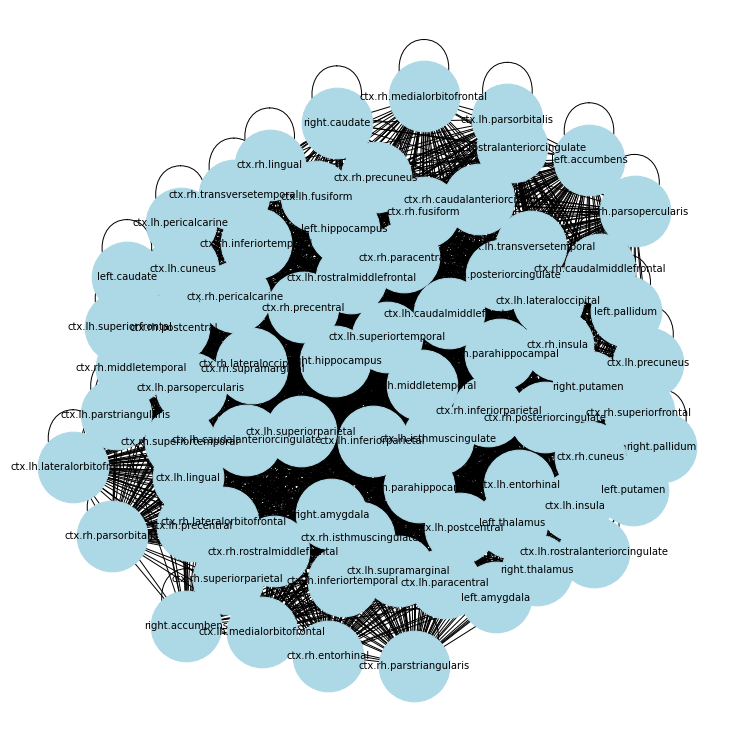

In [43]:
G_namedd = nx.Graph()

for node_id, node_name in node_id_to_name.items():
    G_namedd.add_node(node_name) 

for node_id in model_fa.wv.index_to_key:  
    for node1, similarity in model_fa.wv.most_similar(0, topn=777): #ITERAR SOBRE UNO CON MAXIMO DE TOPN q como max es 76
        if int(node1) in node_id_to_name and int(node_id) in node_id_to_name:
            name1 = node_id_to_name[int(node_id)]
            name2 = node_id_to_name[int(node1)]
            G_namedd.add_edge(name1, name2, weight=similarity)


print(f"Número de nodos: {G_namedd.number_of_nodes()}")
print(f"Número de aristas: {G_namedd.number_of_edges()}")


plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_namedd)  
nx.draw(G_namedd, pos, with_labels=True, node_size=5000, node_color="lightblue", font_size=10)
plt.show()

Número de nodos: 76
Número de aristas: 272


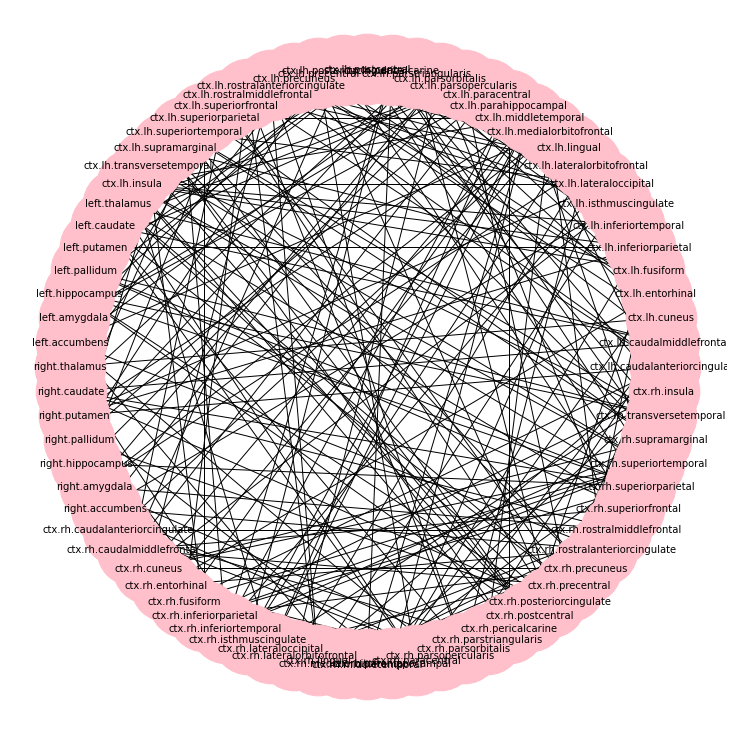

In [44]:
G_named_FA = nx.Graph()

for node_id, node_name in node_id_to_name.items():
    G_named_FA.add_node(node_name)  

for node_id in model_fa.wv.index_to_key:  # Iterar sobre TOOODOOSSS los nodos en el modelo
    for node1, similarity in model_fa.wv.most_similar(node_id, topn=5):
        if int(node1) in node_id_to_name and int(node_id) in node_id_to_name:
            name1 = node_id_to_name[int(node_id)]
            name2 = node_id_to_name[int(node1)]
            G_named_FA.add_edge(name1, name2, weight=similarity)


print(f"Número de nodos: {G_named_FA.number_of_nodes()}")
print(f"Número de aristas: {G_named_FA.number_of_edges()}")



plt.figure(figsize=(10, 10))
pos = nx.circular_layout(G_named_FA) 
nx.draw(G_named_FA, pos, with_labels=True, node_size=5000, node_color="pink", font_size=10)
plt.show()

Número de nodos: 76
Número de aristas: 277


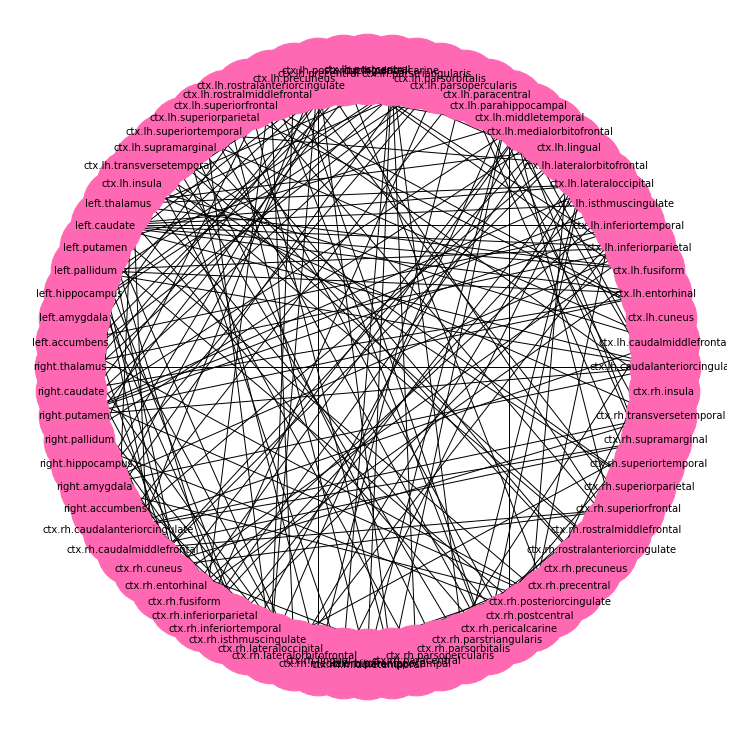

In [45]:
G_named_GM = nx.Graph()

for node_id, node_name in node_id_to_name.items():
    G_named_GM.add_node(node_name) 

for node_id in model_GM.wv.index_to_key:  # Iterar sobre TOOODOOSSS los nodos en el modelo
    for node1, similarity in model_GM.wv.most_similar(node_id, topn=5):
        if int(node1) in node_id_to_name and int(node_id) in node_id_to_name:
            name1 = node_id_to_name[int(node_id)]
            name2 = node_id_to_name[int(node1)]
            G_named_GM.add_edge(name1, name2, weight=similarity)


print(f"Número de nodos: {G_named_GM.number_of_nodes()}")
print(f"Número de aristas: {G_named_GM.number_of_edges()}")


plt.figure(figsize=(10, 10))
pos = nx.circular_layout(G_named_GM)  # Disposición de los nodos
nx.draw(G_named_GM, pos, with_labels=True, node_size=5000, node_color="hotpink", font_size=10)
plt.show()

Número de nodos: 76
Número de aristas: 263


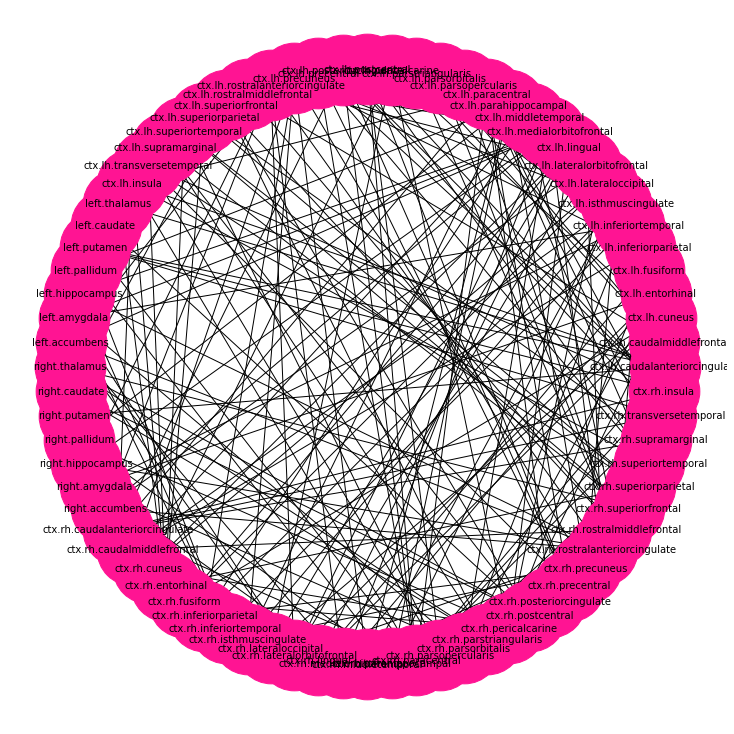

In [46]:
G_named_RS = nx.Graph()


for node_id, node_name in node_id_to_name.items():
    G_named_RS.add_node(node_name)  # Añadir el nodo usando su nombre

for node_id in model_RS.wv.index_to_key:  # Iterar sobre TOOODOOSSS los nodos en el modelo
    for node1, similarity in model_RS.wv.most_similar(node_id, topn=5):
        if int(node1) in node_id_to_name and int(node_id) in node_id_to_name:
            name1 = node_id_to_name[int(node_id)]
            name2 = node_id_to_name[int(node1)]
            G_named_RS.add_edge(name1, name2, weight=similarity)


print(f"Número de nodos: {G_named_RS.number_of_nodes()}")
print(f"Número de aristas: {G_named_RS.number_of_edges()}")


plt.figure(figsize=(10, 10))
pos = nx.circular_layout(G_named_RS)  
nx.draw(G_named_RS, pos, with_labels=True, node_size=5000, node_color="deeppink", font_size=10)
plt.show()